# A Movie behind a Script


In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as psf
from pyspark.sql.utils import AnalysisException

from sacremoses import MosesDetokenizer

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim

#Gensim
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# Overview of datasets

The OpenSubtitles dataset is a compressed cluster of folders containing XML files. Each XML file is split into a script portion with the subtitles of the movie and a metadata portion with additional information about the movie or show. The name of the second-parent folder of the XML file is the corresponding IMDb identifier of the movie or show, thus allowing us to extract additional information from the IMDb dataset.

## IMDb Dataset

We use the IMDb basics dataset, which provides us with a title's main information, and the ratings datasets, which provides us the IMDb rating and votes information for each title.

In [3]:
df_basics = spark.read.parquet("parquets/basics.parquet")
df_basics.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: double (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [4]:
df_ratings = spark.read.parquet("parquets/ratings.parquet")
df_ratings.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- averageRating: float (nullable = true)
 |-- numVotes: integer (nullable = true)



## OpenSubtitles dataset

The dataset consists of 31 GB of XML files distributed in the following file structure: 

```
├── opensubtitle
│   ├── OpenSubtitles2018
│   │   ├── Year
│   │   │   ├── Id
│   │   │   │   ├── #######.xml.gz
│   │   │   │   ├── #######.xml.gz
│   ├── en.tar.gz
│   ├── fr.tar.gz
│   ├── zh_cn.tar.gz
```
where
- `######` is a 6-digit unique identifier of the file on the OpenSubtitles dataset.
- `Year` is the year the movie or episode was made.
- `Id` is a 5 to 7 digit identifier (if it's 7-digit it's also an IMDb identifier).

The subtitles are provided in different languages. We only analyze the `OpenSubtitles2018` folder and it's the only folder we detail.

The decompressed XML files vary in size, ranging from 5KB to 9000KB sized files.

Each XML file is split into a `document` and `metadata` section.

### Document

The `document` section contains all the **subtitles** and its general structure is the following:

```
├── s
│   ├── time: Integer
│   ├── w: String
```

An example snippet of an XML file:

```xml
  <s id="1">
    <time id="T1S" value="00:00:51,819" />
    <w id="1.1">Travis</w>
    <w id="1.2">.</w>
    <time id="T1E" value="00:00:53,352" />
  </s>
```

The subtitles in each XML file are stored by **blocks** denoted by `s` with a unique `id` attribute (integers in increasing order starting at 1).  

Each block (`<s id="1">` for instance) has a:  

1. Set of timestamps (denoted by `time`) with
 - A timestamp `id` attribute that can take two different formats: `T#S` or `T#E`, where _S_ indicates _start_, _E_ indicates _end_ and _#_ is an increasing integer. 
 - A `value` attribute which has the format `HH:mm:ss,fff`.

2. Set of words (denoted by `w`) with
 - an `id` attribute that is simply an increasing number of decimal numbers of the format `X.Y` where X is the string id and Y is the word id within the corresponding string
 - a non-empty `value` attribute that contains a token: a word or a punctuation character. 

It sometimes also has an `alternative`, `initial` and `emphasis` attribute.  

 - The `initial` attribute generally corresponds to slang words or mispronounced words because of an accent such as _lyin'_ instead of _lying_.  
 - The `alternative` attribute is another way of displaying the subtitle for example _HOW_ instead of _how_.
 - The `emphasis` attribute is a boolean.

### Metadata

The `metadata` section has the following structure:

```
├── Conversion
│   ├── corrected_words: Integer
│   ├── sentences: Integer
│   ├── tokens: Integer
│   ├── encoding: String (always utf-8)
│   ├── unknown_words: Integer
│   ├── ignored_blocks: Integer
│   ├── truecased_words: Integer
├── Subtitle
│   ├── language: String
│   ├── date: String
│   ├── duration: String
│   ├── cds: String (presented as #/# where # is an int)
│   ├── blocks: Integer
│   ├── confidence: Double
├── Source
│   ├── genre: String[] (up to 3 genres)
│   ├── year: Integer
│   ├── duration: Integer (in minutes)
│   ├── original: String
│   ├── country: String
```

We note that some XML files may not have all the entries. 
We can use the metadata to obtain additional information about the movie or show's subtitles and compute certain statistics. 

## Comments on the OpenSubtitle Dataset

Going through the dataset we notice a few things:

1. The dataset has meaningless folders. For example, the folder 1858/ is empty.
2. Dataset contains XML files that are not related to movies or TV shows. For example, the folder 666/ contains Justin Bieber song subtitles.  
3. Trailer of films can be present in the dataset. For example, the folder 2018/ we found for example Black Panther teaser trailer subtitles.
4. Each movie might have more than 1 subtitle file.
5. Some subtitle files contain text that is not related to the movie, like credits to the person who made the subtitles.
7. Each block may have an arbitrary number (including 0) of timestamps associated to it.

To solve points 1, 2 and 3 we decide to take only files associated with valid IMDb id's of movies with more than 5000 reviews.

To solve point 4, we simply take the largest files.

To solve point 6, we keep movies that have a correct IMDb identifier. Hence, all the files in folders that don't have a 7-digit folder name are dropped.

To solve point 7, we decide not to associate a timestamp to each word.
 
We extract the desired dataset information into a parquet file using the script `parquet2.py`. From this parquet we extract all the information for the data analysis.

Moreover, to avoid confusion, we set some naming conventions. We refer to certain attributes as follows:

- The `s` array as **blocks**
- An element of blocks, as a **block**.
- The `w` array as **elements**
- An element of elements, as **element**.
- `_VALUE` as a **token**
- A **subtitle** is a list of tokens

# Data analysis

## Objective and structure

As stated in our abstract, our main goal is to try to find a relation between a film subtitles and the average rating: __What makes a movie good or bad?__  

To answer the question we follow this structured plan:
1. **Data cleaning and selection**: Select and clean data relevant to our problem.
2. **Data exploration**: Analyze the distribution of different features of our data, such as most represented genres, years, etc.
3. **Extraction of features** from the subtitles. Try to find correlations between such features and movies average ratings.
4. **Linear regression implementation** using such statistics.
5. **Natural Language Processing (NLP)**: Use NLP tools such as sentiment analysis and topic detection to extract additional information.
6. **Conclusion**

## Data selection

To see if one can predict the average IMDb rating using the subtitles of a movie, the data is restricted according to the following criteria:
1. __the movie must have been rated at least 5000 times__: indeed we consider this a good minimum threshold to estimate the public approval of a film. In comparison, for a movie to be included in the IMDb top 250 movies, a movie must receive at least 25,000 user ratings.
2. __the file identifier must be a valid IMDb identifier__: this ensures that the corresponding IMDb data is present in the `basics` and `rating`. 
3. __the title type must be of a movie__.

We also define helper functions :

- a function that retrieves the tokens from the elements (`w` array) and returns an array of subtitles, where each subtitle is a list of tokens.
- a function to split the genres. Multiple genres are provided as a single string, so we must define a function to split the string and return an array of genres.
- a function that joins all the words of a movie
- a function that determines whether an XML document has the correct schema and can thus be processed for our analysis.

The helper functions help us fulfill certain criteria laid out above. The script `parquet2.py` is ran on the cluster to load the `.xml` files into a spark dataframe containing the movie information required for our analysis, which is then stored in a parquet file for convenience.

In [5]:
def to_subtitles_array(sentences):
    """Function to map the elements (a struct containing tokens)
    to a list of list of tokens """
    s_list = []
    if sentences is None:
        return s_list
    for words in sentences:
        w_list = []
        if words and "w" in words and words["w"]:
            for w in words["w"]:
                if '_VALUE' in w and w['_VALUE']:
                    w_list.append(w['_VALUE'])
                
            s_list.append(w_list)

    return s_list

In [6]:
# Function to split genres
udf_split = psf.udf(lambda s: s.split(',') if s is not None else "", ArrayType(StringType()))

In [7]:
# Transform to spark function
udf_subtitles_array = psf.udf(to_subtitles_array, ArrayType(ArrayType(StringType())))
# Convert array of words into a single string
udf_sentence = psf.udf(lambda x: ' '.join(x), StringType())

In [8]:
# Check correct schema
def has_correct_schema(df):
    arguments = ["meta.conversion.sentences",
                 "meta.source.year", 
                 "meta.subtitle.blocks",
                 "meta.subtitle.duration",
                 "meta.subtitle.language",
                 "s"]
    for col in arguments:
        try:
            df[col]
        except AnalysisException:
            return False
    return True

schema_films = StructType([StructField('tconst', StringType(), False),
                           StructField('num_sentences', LongType(), True),
                           StructField('year', LongType(), True),
                           StructField('blocks', LongType(), True),
                           StructField('subtitle_mins', DoubleType(), True),
                           StructField('subtitles', ArrayType(ArrayType(StringType())), True)])

The function below structures our data to the format we want to then process all the queries we need. 
We link the movie with the proper IMDb id, we get all the subtitles and convert the subtitle duration to seconds.

In [9]:
def clean_df(df_document, imdb_id):
    """Restructures and selects the columns of a dataframe of an XML
    file with its corresponding IMDB Id"""
    # Create IMDb ID and subtitles column
    df_film_sentences = df_document.withColumn("tconst", psf.lit("tt" + imdb_id))\
                                   .withColumn("subtitles", udf_subtitles_array("s"))
    
    # Select metadata and previously created columns
    df_result = df_film_sentences.selectExpr("tconst",
                                             "meta.conversion.sentences as num_sentences",
                                             "meta.source.year", 
                                             "meta.subtitle.blocks",
                                             "meta.subtitle.duration as subtitle_duration",
                                             "meta.subtitle.language",
                                             "subtitles")
    # Split genre column and convert subtitle duration to seconds
    df_result = df_result.withColumn("subtitle_mins", 
                                     psf.unix_timestamp(df_result.subtitle_duration, "HH:mm:ss,SSS") / 60)
    # Discard redundant columns
    df_result =  df_result.select("tconst", 
                                  "num_sentences", 
                                  "year", 
                                  "blocks", 
                                  psf.when(psf.col("subtitle_mins") > 0, psf.col("subtitle_mins"))\
                                     .otherwise(None)\
                                     .alias("subtitle_mins"), 
                                  "subtitles")
    return df_result

As we must process several XML files into dataframe, we define a function that does this.

In [10]:
def load_df(path):
    """Load an XML subtitles file into a dataframe"""
    df_film = sqlContext.read.format('com.databricks.spark.xml')\
                             .options(rowTag='document')\
                             .load(path)
    return df_film

We can't generate a single parquet file for all of our movies in one process, so we use the following function to merge several parquet files onto 1.

In [11]:
def unionAll(*dfs):
    first, rest = dfs[0], dfs[1:]  # Python 3.x, for 2.x you'll have to unpack manually
    return first.sql_ctx.createDataFrame(first.sql_ctx._sc.union([df.rdd for df in dfs]),
                                         first.schema)

The data can be accessed by loading `films.parquet` and `films2.parquet` into a spark dataframe. The first one contains in the subtitle column only the words present in the film and the second one also includes the punctuation marks.

## Data cleaning

In [12]:
# Load data 
df_films = spark.read.parquet('parquets/films.parquet')
df_films.count()

4286

We check if we have any null values that might affect our statistics.

In [13]:
df_films.dropna().count()

4224

The number is fairly small and is due to the conversion of subtitle minutes of some XML files that had a slightly different datetime format. We drop films with null values to avoid incorrect data.

In [14]:
df_films_clean = df_films.dropna()

We also noticed that some movies have the feature `subtitle_mins` with a negative value. This is a non-sense as it represents the time during which subtitles are displayed on the screen. We decided to drop this rows as well. 

In [15]:
df_films = df_films.filter(df_films['subtitle_mins'] > 0)      

In [16]:
# Save the dataframe 
#df_films_clean.write.mode("overwrite").parquet("parquets/films_2.parquet")

In [17]:
# Same for films2.parquet
df_films2 = spark.read.parquet('parquets/films2.parquet')
df_films2_clean = df_films2.dropna()
df_films2_clean = df_films2.filter(df_films2['subtitle_mins'] > 0)        
#df_films_clean.write.mode("overwrite").parquet("parquets/films2_2.parquet")

## Data exploration

In [18]:
df_films = spark.read.parquet("parquets/films_2.parquet")

So far we consider the following number of movies : 

In [19]:
df_films.count()

4224

The dataframe we work with has the following form:

In [20]:
df_films.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- num_sentences: long (nullable = true)
 |-- year: long (nullable = true)
 |-- blocks: long (nullable = true)
 |-- subtitle_mins: double (nullable = true)
 |-- subtitles: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)



We first make a simple exploration of our dataset, joining it with the IMDb ratings dataframe.

In [21]:
# Get the movie length and the genres 
df_movies = df_basics.filter(df_basics['titleType'] == 'movie')\
                     .select('tconst','originalTitle','runtimeMinutes','genres',)\
                     .join(df_ratings.filter(df_ratings.numVotes >= 5000)\
                                     .select('tconst','averageRating'),
                           on="tconst")

In [22]:
# Take the entries matching the opensubtitle data
df_films_stats = df_films.join(df_movies,["tconst"])\
                         .drop("subtitles")\
                         .toPandas()

### Runtime and ratings

#### How is the total film runtime distributed?

Shortest movie in our dataset is 60.0 minutes long
Longest movie in our dataset is 467.0 minutes long


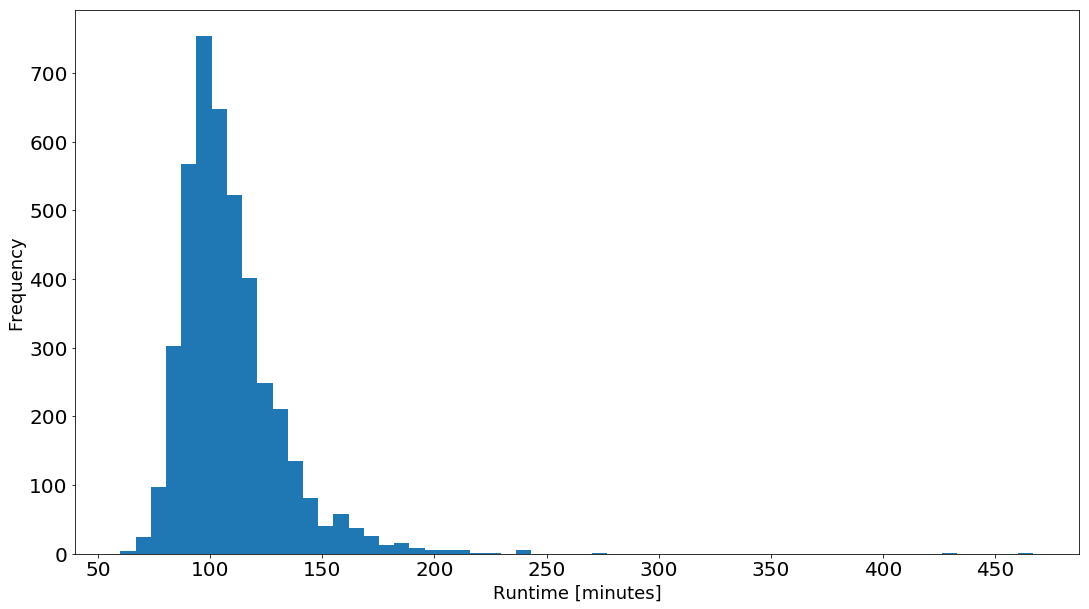

In [23]:
print("Shortest movie in our dataset is {:} minutes long".format(df_films_stats["runtimeMinutes"].min()))
print("Longest movie in our dataset is {:} minutes long".format(df_films_stats["runtimeMinutes"].max()))

ax = df_films_stats["runtimeMinutes"].plot.hist(bins=60, figsize=(18,10), fontsize=20)
ax.set_xlabel("Runtime [minutes]", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18);

We see that most of the is grouped around a movie length of a 100 minutes. 

To check wether this feature has an impact on the IMDb average rating, we look at the `Movie length` vs `IMDb average rating` plot. 

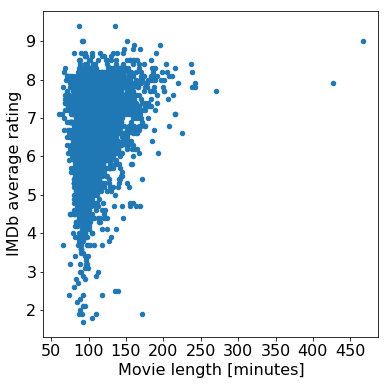

In [24]:
ax = df_films_stats.plot(kind="scatter",
                         x="runtimeMinutes",
                         y="averageRating",
                         fontsize=16,
                         figsize=(6,6))

ax.set_xlabel("Movie length [minutes]", fontsize=16)
ax.set_ylabel("IMDb average rating", fontsize=16)
plt.show()

We observe that the dispersion of the IMDb average rating decreases with the length of the movie as if longer movies are better than shorter ones. 
This variation tells us that the length of the movie is not a relevant feature to characterize "good" movies but only that "bad" movies tend to be shorter. 

The two outliers present in the data are _Voyna i mir (1966)_ and _O.J.: Made in America (2016)_ that last respectively 7h 07min and 7h 47min.
Although this can be considered as outliers, the features associated with these movies do not indicate any problem with respect to their subtitles. 

As a consequence, we do not discard these movies from the dataset but the features that we will use to try to predict the average rating will be relative to the length of the movie or another value that take into account the "size" of the movies.  

#### How are the ratings distributed?

Worst movie rating in our dataset is 1.7
Best movie movie rating in our dataset is 9.4
Average rating in our dataset is 6.7


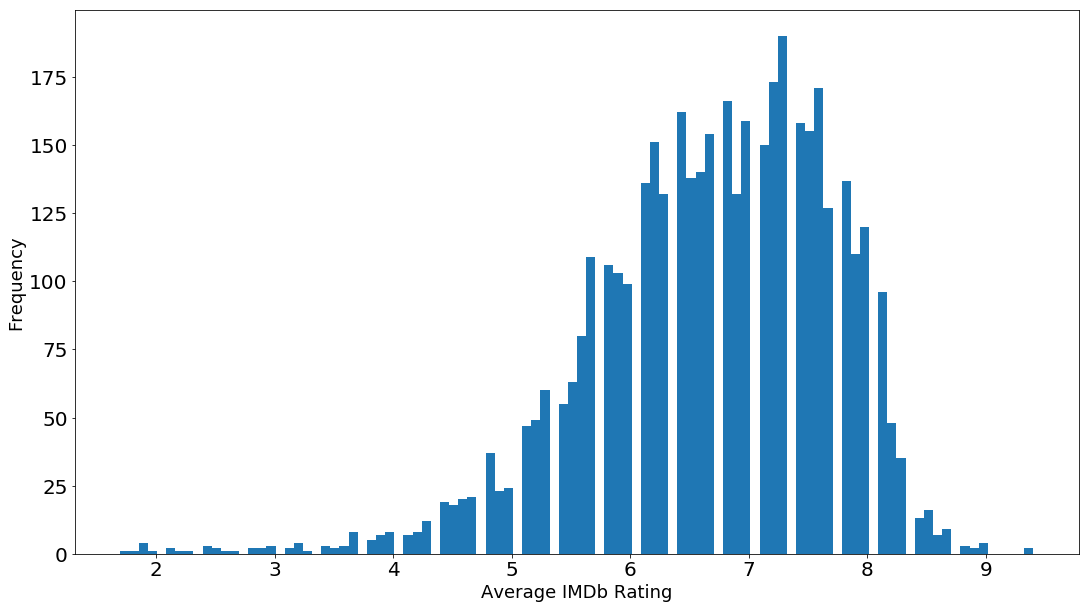

In [25]:
print("Worst movie rating in our dataset is {:.1f}".format(df_films_stats["averageRating"].min()))
print("Best movie movie rating in our dataset is {:.1f}".format(df_films_stats["averageRating"].max()))
print("Average rating in our dataset is {:.1f}".format(df_films_stats["averageRating"].mean()))
ax = df_films_stats["averageRating"].plot.hist(bins=100, figsize=(18,10), fontsize=20)
ax.set_xlabel("Average IMDb Rating", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18);

This graphs shows that a "good" movie would be a movie that has a rating higher than 6.7 .
We choose to consider a good movie as having a minimum rating of 8. 
A movie will be considered to be "bad" if it is has a rating of less than 5.2.
The value of 5.2 is chosen to have balanced classes. 

### Time Exploration

Oldest movie in our dataset was released in 1922
Newest movie in our dataset was released in 2017


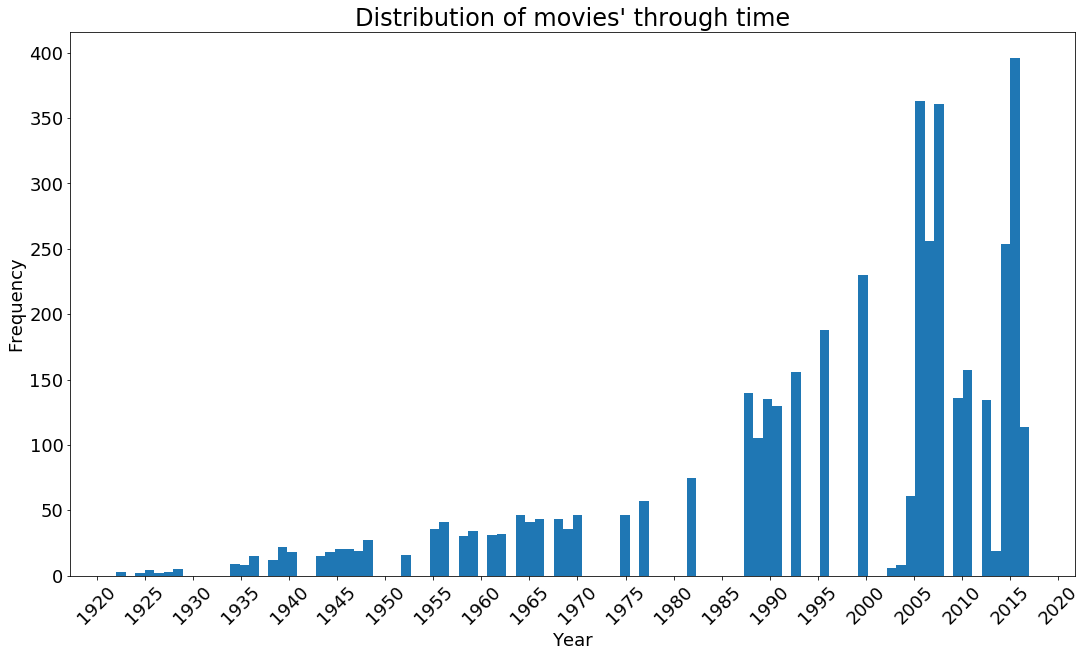

In [26]:
print("Oldest movie in our dataset was released in {:}".format(df_films_stats["year"].min()))
print("Newest movie in our dataset was released in {:}".format(df_films_stats["year"].max()))
ax = df_films_stats["year"].plot.hist(bins=96, figsize=(18,10), fontsize=18)
ax.set_xticks(np.arange(1920, 2021, 5))
plt.xticks(rotation=45)
ax.set_title("Distribution of movies' through time", fontsize=24)
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18);

We see that the data is not evenly distributed through time. A lot of years are missing and we notice that we have much more recent films than old ones in our dataset. We believe this is largely due to several economic and technological factors:
- More data has been collected in recent years.
- It has become easier and cheaper to make a movie. Independently made movies for instance have increased in popularity.
- Economic growth and improvements in technology mean imply that more people have access to TV entertainment
- General increase in the TV entertainment industry

All in all, we believe that due to the uneven distribution of movies across time, it will be difficult to take time as a good feature to predict the rating. 

We categorize our subtitles distribution into 3 time periods as we have seen that our dataset is not balanced in terms of distribution through time. We extract the average rating of each period, aswell as the rating by genre.

In [27]:
def add_time_period(year):
    if year < 1910 or year > 2018:
        return "NaN"
    elif year < 1960:
        return "1910-1959"
    elif year < 2000:
        return "1960-1999"
    else:
        return "2000s"
udf_period = psf.udf(add_time_period, StringType())

In [28]:
df_ratings_periods = df_movies.join(df_films.select("year", "tconst"), ["tconst"])\
                                            .withColumn("period", udf_period("year"))

In [29]:
df_ratings_periods.groupBy("period")\
                  .agg({"averageRating": "mean", "*": "count"})\
                  .show()

+---------+------------------+--------+
|   period|avg(averageRating)|count(1)|
+---------+------------------+--------+
|    2000s| 6.465611225999668|    2495|
|1910-1959| 7.583113493579673|     379|
|1960-1999| 6.831037049823337|    1350|
+---------+------------------+--------+



__Are films getting worse?__  

We notice a decrease in average rating over time. It seems that recent movies tend to have a worse average rating, while the best films are the older ones. The amount of movies in the period 1910-1959 is much smaller than the amount of movies in the 2000s so we cannot conclude that movies in the 1910-1959 period are better than movies in the 2000s. We attribute this discrepancy to the idea that more data has been collected in recent years, regardless of whether movies are "good" or "bad", while subtitles available for old movies are primarily for "good" movies.

### Genre Exploration

We retrieve the distribution of the genres that appear in our dataset. We also consider that a movie can have multiple genres.

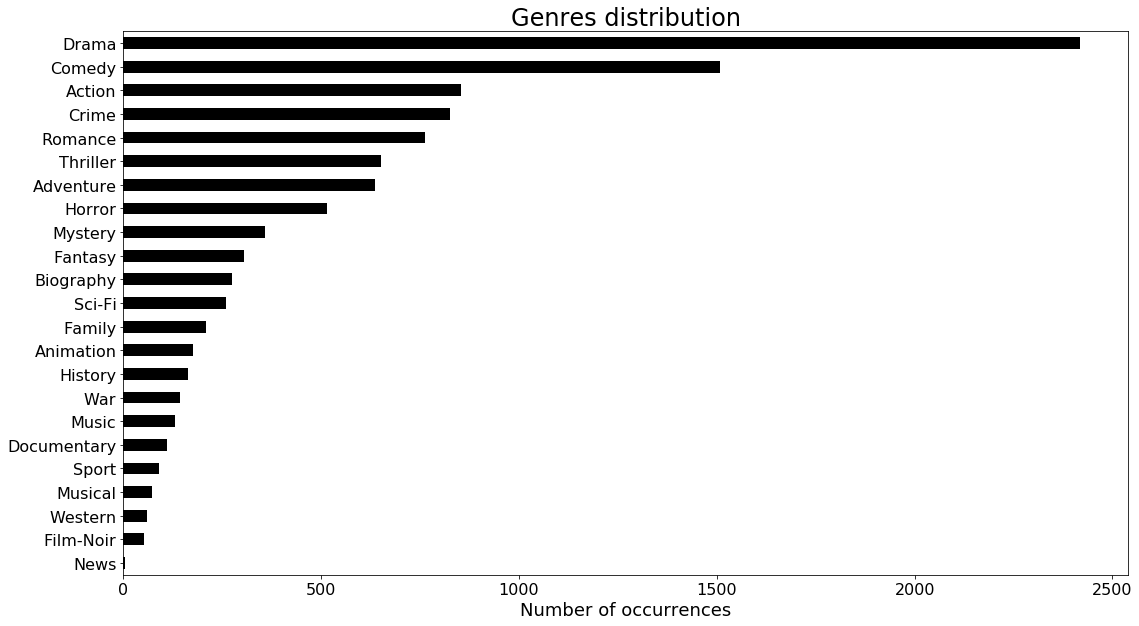

In [30]:
genres = [item for sublist in df_films_stats["genres"] for item in sublist]
sorted_genres = pd.Series(genres).groupby(genres).count().sort_values()
ax = sorted_genres.plot.barh(figsize=(18,10), fontsize=16, color = 'black')
ax.set_title("Genres distribution", fontsize=24)
ax.set_xlabel("Number of occurrences", fontsize=18);

Since we are only left with around 4,000 films after the data cleaning, we compare the 10 most represented genres' average rating in our dataset to the genres' average IMDb rating on the whole IMDb dataset.

In [31]:
df_genres = df_films.drop("subtitles").join(df_movies, ["tconst"])

In [32]:
df_genres_avRating = df_genres.select('*', 
                                      psf.explode('genres').alias('genre'))\
                              .groupBy("genre").agg({"averageRating": "mean", 
                                                     "*": "count"})
df_genres_rating = df_genres_avRating.sort("count(1)", ascending=False)\
                                     .limit(10)\
                                     .withColumnRenamed("avg(averageRating)", "OpenSubtitles2018 rating")\
                                     .drop("count(1)")

In [33]:
df_imdb_avRating = df_movies.select('*', psf.explode('genres').alias('genre'))\
                            .groupBy("genre")\
                            .agg({"averageRating": "mean", 
                                  "*": "count"})
df_imdb_avRating = df_imdb_avRating.sort("count(1)", ascending=False)\
                                   .limit(10)\
                                   .withColumnRenamed("avg(averageRating)", "IMDb rating")\
                                   .drop("count(1)")
df_all_ratings = df_imdb_avRating.join(df_genres_rating, ["genre"]).toPandas()

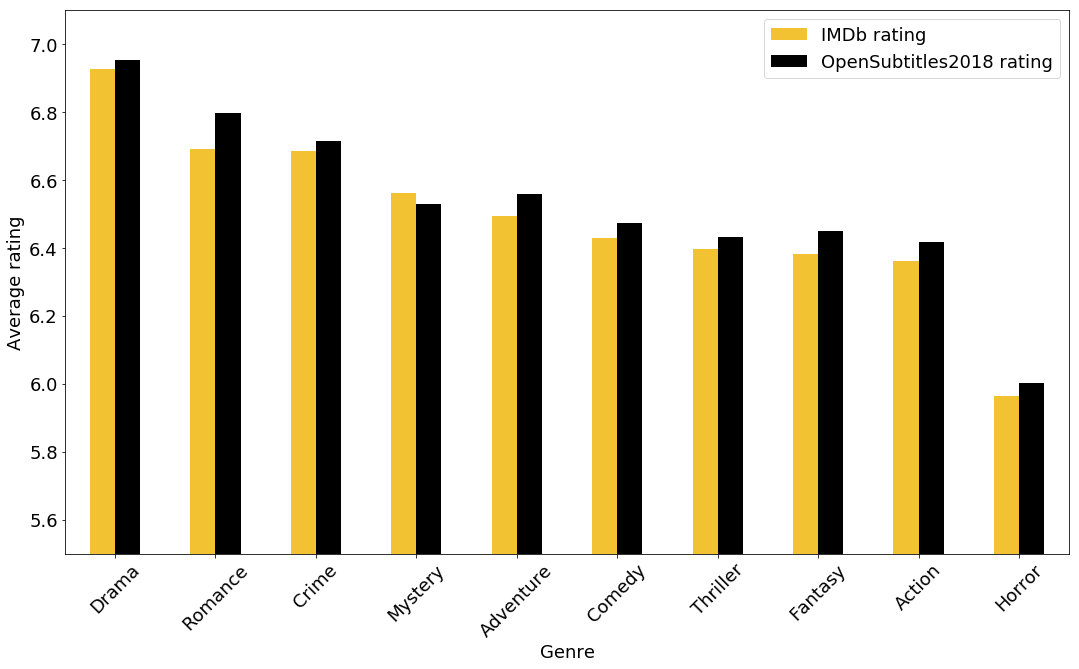

In [34]:
yvar = ["IMDb rating", "OpenSubtitles2018 rating"]
sorted_ratings = df_all_ratings.sort_values("IMDb rating", ascending=False)
ax = sorted_ratings.plot.bar(y=yvar, 
                             x="genre", 
                             figsize=(18,10), 
                             fontsize=18, 
                             color=[(0.95, 0.76, 0.2), "black"])
ax.set_xlabel("Genre", fontsize=18)
ax.set_ylabel("Average rating", fontsize=18)
plt.legend(fontsize=18)
plt.ylim(5.5, 7.1)
plt.xticks(rotation=45)
plt.show()

We see that for each genre there isn't much difference between the average IMDb rating and the OpenSubtitles2018 rating. Each genre's average IMDb rating in our dataset is fairly representative of the overall IMDb rating. We also notice the wide gap between Drama movies'  and Horror movies' average rating. We can therefore hypothesize that a movie's genre has an influence on its average rating. We also note that as our dataset is smaller, average values are more greatly impacted by outliers.

With these ideas in mind, we check the distribution of average rating for the different genres present in our dataset for the different time periods. 

In [35]:
df_periods_stats = df_ratings_periods.join(other=df_genres.select("tconst",
                                                                  psf.explode('genres').alias('genre')),
                                           on=["tconst"])\
                                     .groupBy("period", "genre").agg({"averageRating": "mean", 
                                                                            "*": "count"})
df_periods_stats_pd = df_periods_stats.toPandas()

In [36]:
df_genres = df_films.drop("subtitles").join(df_basics.select("tconst", 
                                                             "genres", 
                                                             "primaryTitle", 
                                                             "runtimeMinutes"), 
                                            ["tconst"])
df_genres = df_genres.join(df_ratings, ["tconst"])

We decide to take film genres only with more than 100 appereances, to have better confidence in our results and we plot by time period again the average rating of each genre. We first look at the whole dataframe to see the "best type of movie" taking into account the period and the genre.

In [37]:
df_genre_period = df_periods_stats_pd[df_periods_stats_pd["count(1)"] > 100].sort_values("count(1)",
                                                                                         ascending=False)

In [38]:
df_genre_period.sort_values("avg(averageRating)", ascending=False)

,period,genre,avg(averageRating),count(1)
61,1910-1959,Drama,7.634457,267
52,1910-1959,Romance,7.581897,116
53,2000s,Biography,7.152717,184
47,1960-1999,Drama,7.139305,748
37,1960-1999,Romance,6.943056,216
64,1960-1999,Crime,6.737943,282
11,1960-1999,Thriller,6.734973,183
9,2000s,Drama,6.731527,1421
32,1960-1999,Adventure,6.689202,213
17,2000s,Animation,6.615267,131


We now plot the average rating for the different genres given a time period

In [39]:
df_table = pd.DataFrame(columns=["1910-1959", "1960-1999", "2000s"],
                        index=set(df_genre_period.genre))

for genre in df_table.index:
    genre_table = df_genre_period[df_genre_period.genre == genre]
    
    for time in df_table.columns:
        array = genre_table[genre_table.period == time]["avg(averageRating)"].values
        
        if len(array):
            df_table.at[genre, time] = array[0]
            
df_table

,1910-1959,1960-1999,2000s
Crime,NaN,6.73794,6.55362
Horror,NaN,6.27042,5.77765
Thriller,NaN,6.73497,6.22864
Biography,NaN,NaN,7.15272
Drama,7.63446,7.1393,6.73153
Comedy,NaN,6.60266,6.27452
Adventure,NaN,6.6892,6.37454
Sci-Fi,NaN,NaN,6.00683
Animation,NaN,NaN,6.61527
Mystery,NaN,NaN,6.26711


The first columns contains. 

From the genre exploration we can say that there is an actual influence on the film average rating but it is difficult to quantify this influence. From the distribution of our dataset we have as well very little information regarding most of the different genres, hence it is not a good practice to use the genre as a metric for a prediction. For example we have a lot of movies in the drama category but very few in the western genre, hence the statistics of westerns should not be trusted.
We will though, implement some NLP tools to find distinct topics of some of the most popular genres to see how they vary and how “good” and “bad” films of a particular genre might differ.

## Simple statistics: searching for a correlation between average IMDb rating and text features. 

In order to predict the average IMDb rating we extracted "raw" features from the subtitles and the metadata : 
* the total number of words relative to the movie duration. 
* the total number of distinct words relative to the movie duration.
* the total number of sentences relative to the movie duration.
* the mean average length of the subtitles.
* the subtitles to movie duration ratio.
* the number of distinct words divided by the length of the movie, the total number of words and the mean average length of the sentences.

We define the following method to extract these features from our dataframe.

In [40]:
def word_statistics(df_films):
    # Explode the sentences t
    df_words = df_films.select('*', psf.explode('subtitles').alias('words'))
    df_words = df_words.select('*', psf.explode('words').alias('word'))

    df_word_counts = df_words.groupby("tconst", "num_sentences", "subtitle_mins")\
                             .agg(psf.count("word").alias("num_words"), 
                                  psf.countDistinct("word").alias("num_distinct_words"))\
                             .join(df_basics, ['tconst'], 'inner')\
                             .withColumn("words_per_min",
                                         psf.col("num_words") / psf.col("runtimeMinutes"))\
                             .withColumn("distinct_words_per_min",
                                         psf.col("num_distinct_words") / psf.col("runtimeMinutes"))\
                             .withColumn("sentences_per_min",
                                         psf.col("num_sentences") / psf.col("runtimeMinutes"))\
                             .withColumn("mean_length_sentences",
                                         psf.col("num_words") / psf.col("num_sentences"))\
                             .withColumn("distinct_index", 
                                         1000 * psf.col("num_distinct_words") /(psf.col("num_sentences")*
                                                                                psf.col("runtimeMinutes")*
                                                                                psf.col("num_words")))\
                             .withColumn("times_ratio",
                                         psf.when(psf.col("subtitle_mins").isNotNull(), 
                                                  psf.col("subtitle_mins") / psf.col("runtimeMinutes") * 100))
    
    df_word_counts = df_word_counts.select("tconst",
                                           "num_words",
                                           "num_distinct_words",
                                           "num_sentences",
                                           "subtitle_mins",
                                           "runtimeMinutes",
                                           "mean_length_sentences",
                                           "words_per_min",
                                           "distinct_words_per_min",
                                           "sentences_per_min",
                                           "distinct_index",
                                           "times_ratio")
    return df_word_counts

In [41]:
# Load data  
df_films = spark.read.parquet("parquets/films_2.parquet")

In [42]:
# Generating the df of statistics 
df_stats = word_statistics(df_films)

### Trailers in the dataset

With this new statisitics computed, we noticed that some trailer subtitles managed to passe through our filters.
To discard those subtitles we look at how many words are used.
We choose to discard subtitles that used less than 600 words.  
The idea is : Eminem in his song "Rap God" had the world record of words pronounced in a given time. 
On averaged he pronounced 4,28 words per sec.
Thus, we expect people to speak at most at 2 words per second. 
If a trailer lasts at maximum 300 seconds, that leads us to 600 words. 
We add 200 to the figure and hence we discard the subtitles that have less than 800 words. 

To add, we remove movies that lead to a higher rate of word per second value.

In [43]:
df_stats = df_stats.filter(df_stats['num_words'] > 800)
df_stats = df_stats.filter(~(df_stats['words_per_min']/60 > 4.28 ))

As we joined the data from IMDb and from OpenSubtitle, we noticed that some subtitles come with larger `subtitle_mins` than the movie lentgh (`runtimeMinutes`). We decide to drop this rows as well as a wrong value of `subtitle_mins` is symptomatic of corrupted subtitles. 

In [44]:
df_stats = df_stats.filter(df_stats['subtitle_mins'] < df_stats['runtimeMinutes'])

In [45]:
df_stats.count()

4116

Hence our analysis will be based on 4127 movies. 

In [46]:
# Save the stats df
#df_stats.write.mode("overwrite").parquet("parquets/stats.parquet")

We then clean the dataframes containg the subtitles.

In [47]:
df_films = df_films.join(df_stats.select('tconst'), ['tconst'])
df_films = df_films.drop_duplicates()
#df_films.write.mode("overwrite").parquet("parquets/films_3.parquet") 

In [48]:
# Apply the same methodology to parquet with ponctuation marks  
df_films = spark.read.parquet("parquets/films2_2.parquet")
df_films = df_films.join(df_stats.select('tconst'), ['tconst'])
df_films = df_films.drop_duplicates()
#df_films.write.mode("overwrite").parquet("parquets/films2_3.parquet")

### Visualization

We provide a descriptive analysis of our features by producing scatter plots and histograms. We convert our Spark dataframe to a Pandas dataframe in order to produce this plots.

#### Conversion to pandas dataframe 

In [49]:
# Load from parquet 
df_words_stats = spark.read.parquet("parquets/stats.parquet")

In [50]:
# join with ratings to get average rating: 
df_words_ratings = df_words_stats.join(other=df_ratings, 
                                       on='tconst', 
                                       how='inner')
# join with basics to get title:
df_words_ratings = df_words_ratings.join(other=df_basics.select('tconst',
                                                                'originalTitle', 
                                                                'titleType'), 
                                         on='tconst', 
                                         how='inner')

In [51]:
df_words_ratings_pd = df_words_ratings.toPandas()

__Features and normalizations__  
* The idea behind the ratios $\frac{\text{Number of words}}{\text{Length of Movie}}$, $\frac{\text{Number of distinct words}}{\text{Length of Movie}}$ and $\frac{\text{Number of sentences}}{\text{Length of Movie}}$ is simply to take into account the fact that in longer movies : 
    * more words coud be employed because there is more time for dialogues or anything that requires text displayed on screen
    * more words could be employed leading to a larger vocabulary span.  
    We tried to push this idea of bringing movies to an equal footing by computing _Distinct index_ which is defined as :  
    
    $$\frac{\text{Number of distinct words}}{\text{Lenght of movie}~\cdot~\text{Number of words}~\cdot~\text{Number of sentences}}$$  
    
    
* The times ratio $\tau_{subs}/ \tau_{movies}$ is computed to measure how much time is used by the subtitles and thus providing an indication of how present dialogues are in a movie. 

* The _number of sentences_ is another characterization of the subtitles at a larger scale that the number of words. 

* The mean length of the sentences is defined as: $\bar{L} = \frac{1}{N}\sum_{s} l_{s}$ where $\bar{L}$ is the average length of the sentences, $l_s$ is the length of the sentence indexed by $s$ and $N$ the total number of sentences in the subtitle of the movie. $l_s$ is simply the number of words in a sentence.

#### Plots and correlations :

Structure of graphs : on the X-axis we put the feature and on the Y-axis the average rating.

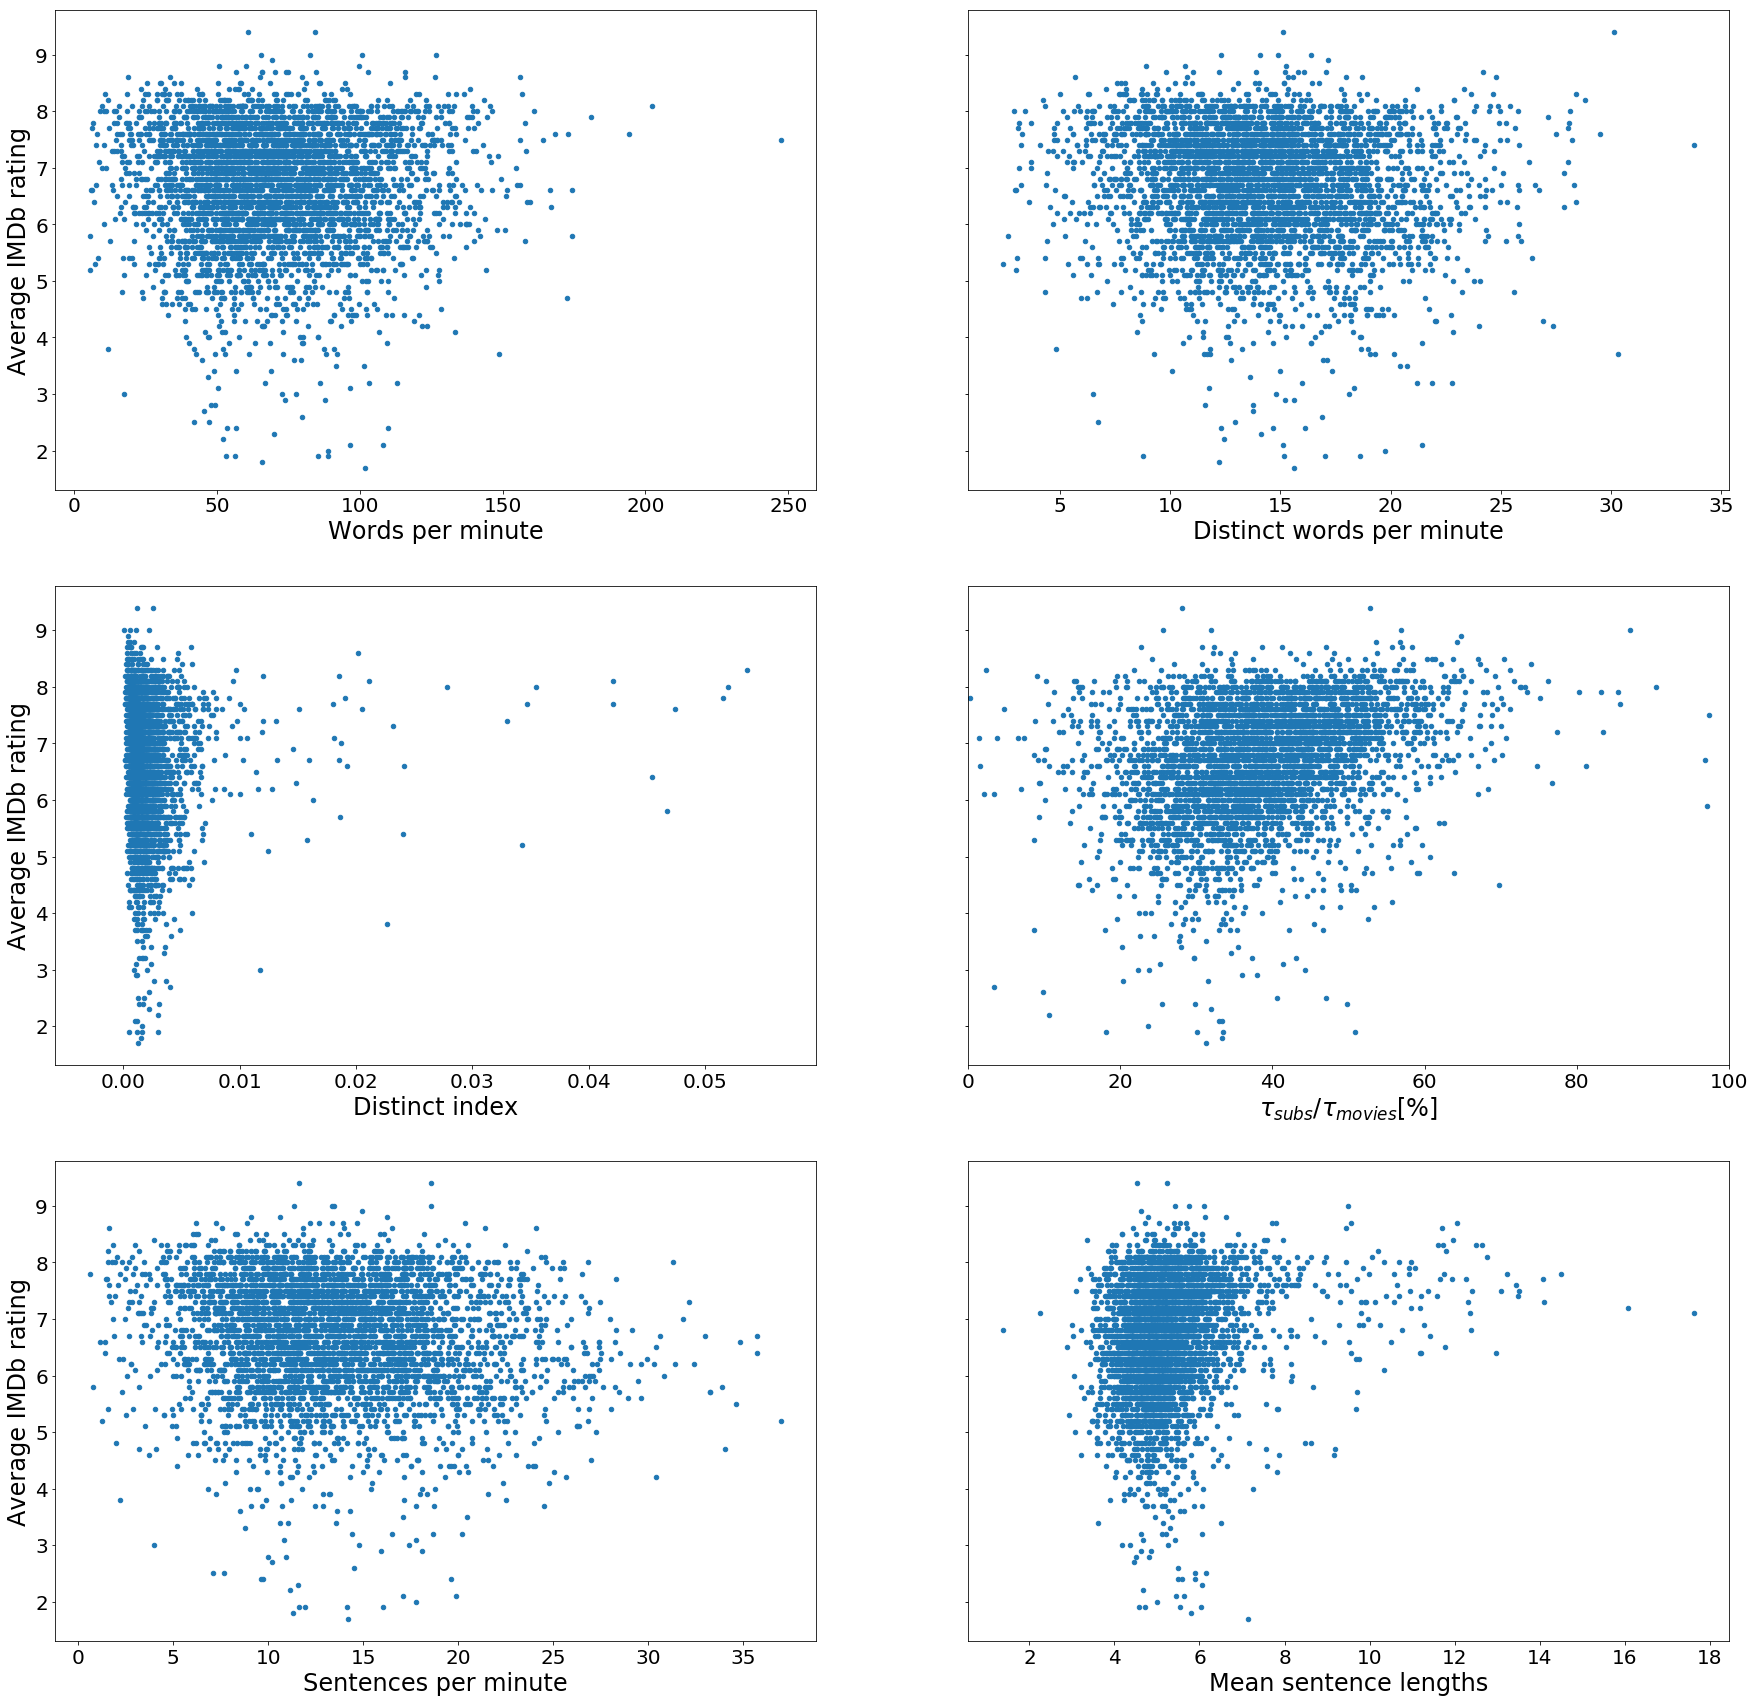

In [52]:
fig, axes = plt.subplots(nrows=3, 
                         ncols=2, 
                         figsize=(30,30))
##############################################
df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[0,0],
                         x="words_per_min",
                         y="averageRating",
                         fontsize=20)
axes[0,0].set_xlabel("Words per minute", 
                     fontsize=24)
axes[0,0].set_ylabel("Average IMDb rating", 
                     fontsize=24)

df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[0,1],
                         sharey=True,
                         x="distinct_words_per_min", 
                         y="averageRating",
                         fontsize=20)
axes[0,1].set_xlabel("Distinct words per minute", 
                     fontsize=24)
##############################################
df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[1,0],
                         x="distinct_index", 
                         y="averageRating",
                         fontsize=20)
axes[1,0].set_xlabel("Distinct index", 
                     fontsize=24)
axes[1,0].set_ylabel("Average IMDb rating", 
                     fontsize=24)

df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[1,1],
                         x="times_ratio", 
                         y="averageRating",
                         fontsize=20)
axes[1,1].set_xlabel("$\\tau_{subs}/ \\tau_{movies} [\\%]$", 
                     fontsize=24)
axes[1,1].set_xlim(0,100);
##############################################
df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[2,0],
                         x="sentences_per_min", 
                         y="averageRating",
                         fontsize=20)
axes[2,0].set_xlabel("Sentences per minute", 
                     fontsize=24)
axes[2,0].set_ylabel("Average IMDb rating", 
                     fontsize=24)

df_words_ratings_pd.plot(kind="scatter",
                         ax=axes[2,1],
                         x="mean_length_sentences", 
                         y="averageRating",
                         fontsize=20)
axes[2,1].set_xlabel("Mean sentence lengths", 
                     fontsize=24);

In [53]:
features = ["words_per_min", "distinct_words_per_min",
            "sentences_per_min","mean_length_sentences",  "distinct_index","times_ratio"]
df_words_ratings_pd.corr()["averageRating"][features]

words_per_min             0.006379
distinct_words_per_min   -0.070648
sentences_per_min        -0.110818
mean_length_sentences     0.197801
distinct_index           -0.002100
times_ratio               0.298069
Name: averageRating, dtype: float64

Looking a the different graphs and the computed correlations, we conclude that no clear tendency can be established. 

__Focus: words per minute, distinct words per minute, distinc index and sentences per minutes__  

Neither _words per minute_, nor _distinct words per minute_ show a clear correlation with the average IMDb rating.
Indeed, the data is largely distributed for every rating present in the dataset.  
Despite this observation, a positive correlation appears between the largest values and the average rating: by following the largest values of these features, the average rating increases with the value of the feature. 
To have a good rating it is not necessary to be more verbose or to employ a larger vocabulary, but it seems that having larger values in these features guarantees a certain rating.

Nevertheless, these correlations are not causalities.  
It can only be understood that "good" movies have well-written dialogues, and thus that the number of (distinct) words used with respect to the movie length, can correlate with the quality of the script.

Looking at the plot of the feature index _Distinct index_ shows the same tendency for extreme values: it seems that larger values of this feature can guarantee a certain average rating.  

A paradox is exposed here : negative correlation were computed but a positive correlations is claimed for the largest values of the features. This is due to the size of the sample considered:
- the negative correlations for _number of distinct words per minute_ and _distinct index_ are computed on the whole dataset
- positive correlation are only observed for extreme values of the features

The same comments apply to _sentences per minute_ : the data is largely distributed. We a have very small negative correlations for the whole 


__Times ratios and mean sentence length__ 

When looking at the graph of _times ratio_ it can be seen that one movie can have very little dialogue and still have a high average IMDb rating, which means that a movie is more than just dialogue and textual elements.
But it also shows that movies where the dialogues take a large place tend to be "good" movies.
Applying the same reasoning as previously: the distribution is more spread as the rating increases. 

_Mean sentence length_ provides another clue on the quality of the textual elements: longer sentences could be indicators of scripts written more cautiously. This idea seems to be confirmed by the positive correlation of 0.2 . 
Unfortunately, as for the other features, a cloud is observed. 

### Histograms

We plot histograms of each feature for films considered "good" and "bad".
Recall that "good" movies have an average rating of at least 8 and that "bad" movies have a rating of less than 5.2 to have similar number of films in each class. 

In [54]:
bad_movies = df_words_ratings_pd[df_words_ratings_pd.averageRating <= 5.2]
good_movies = df_words_ratings_pd[df_words_ratings_pd.averageRating >= 8]

In [55]:
print("Number of bad movies: {}".format(bad_movies["tconst"].count())) 
print("Number of good movies: {}".format(good_movies["tconst"].count()))

Number of bad movies: 349
Number of good movies: 336


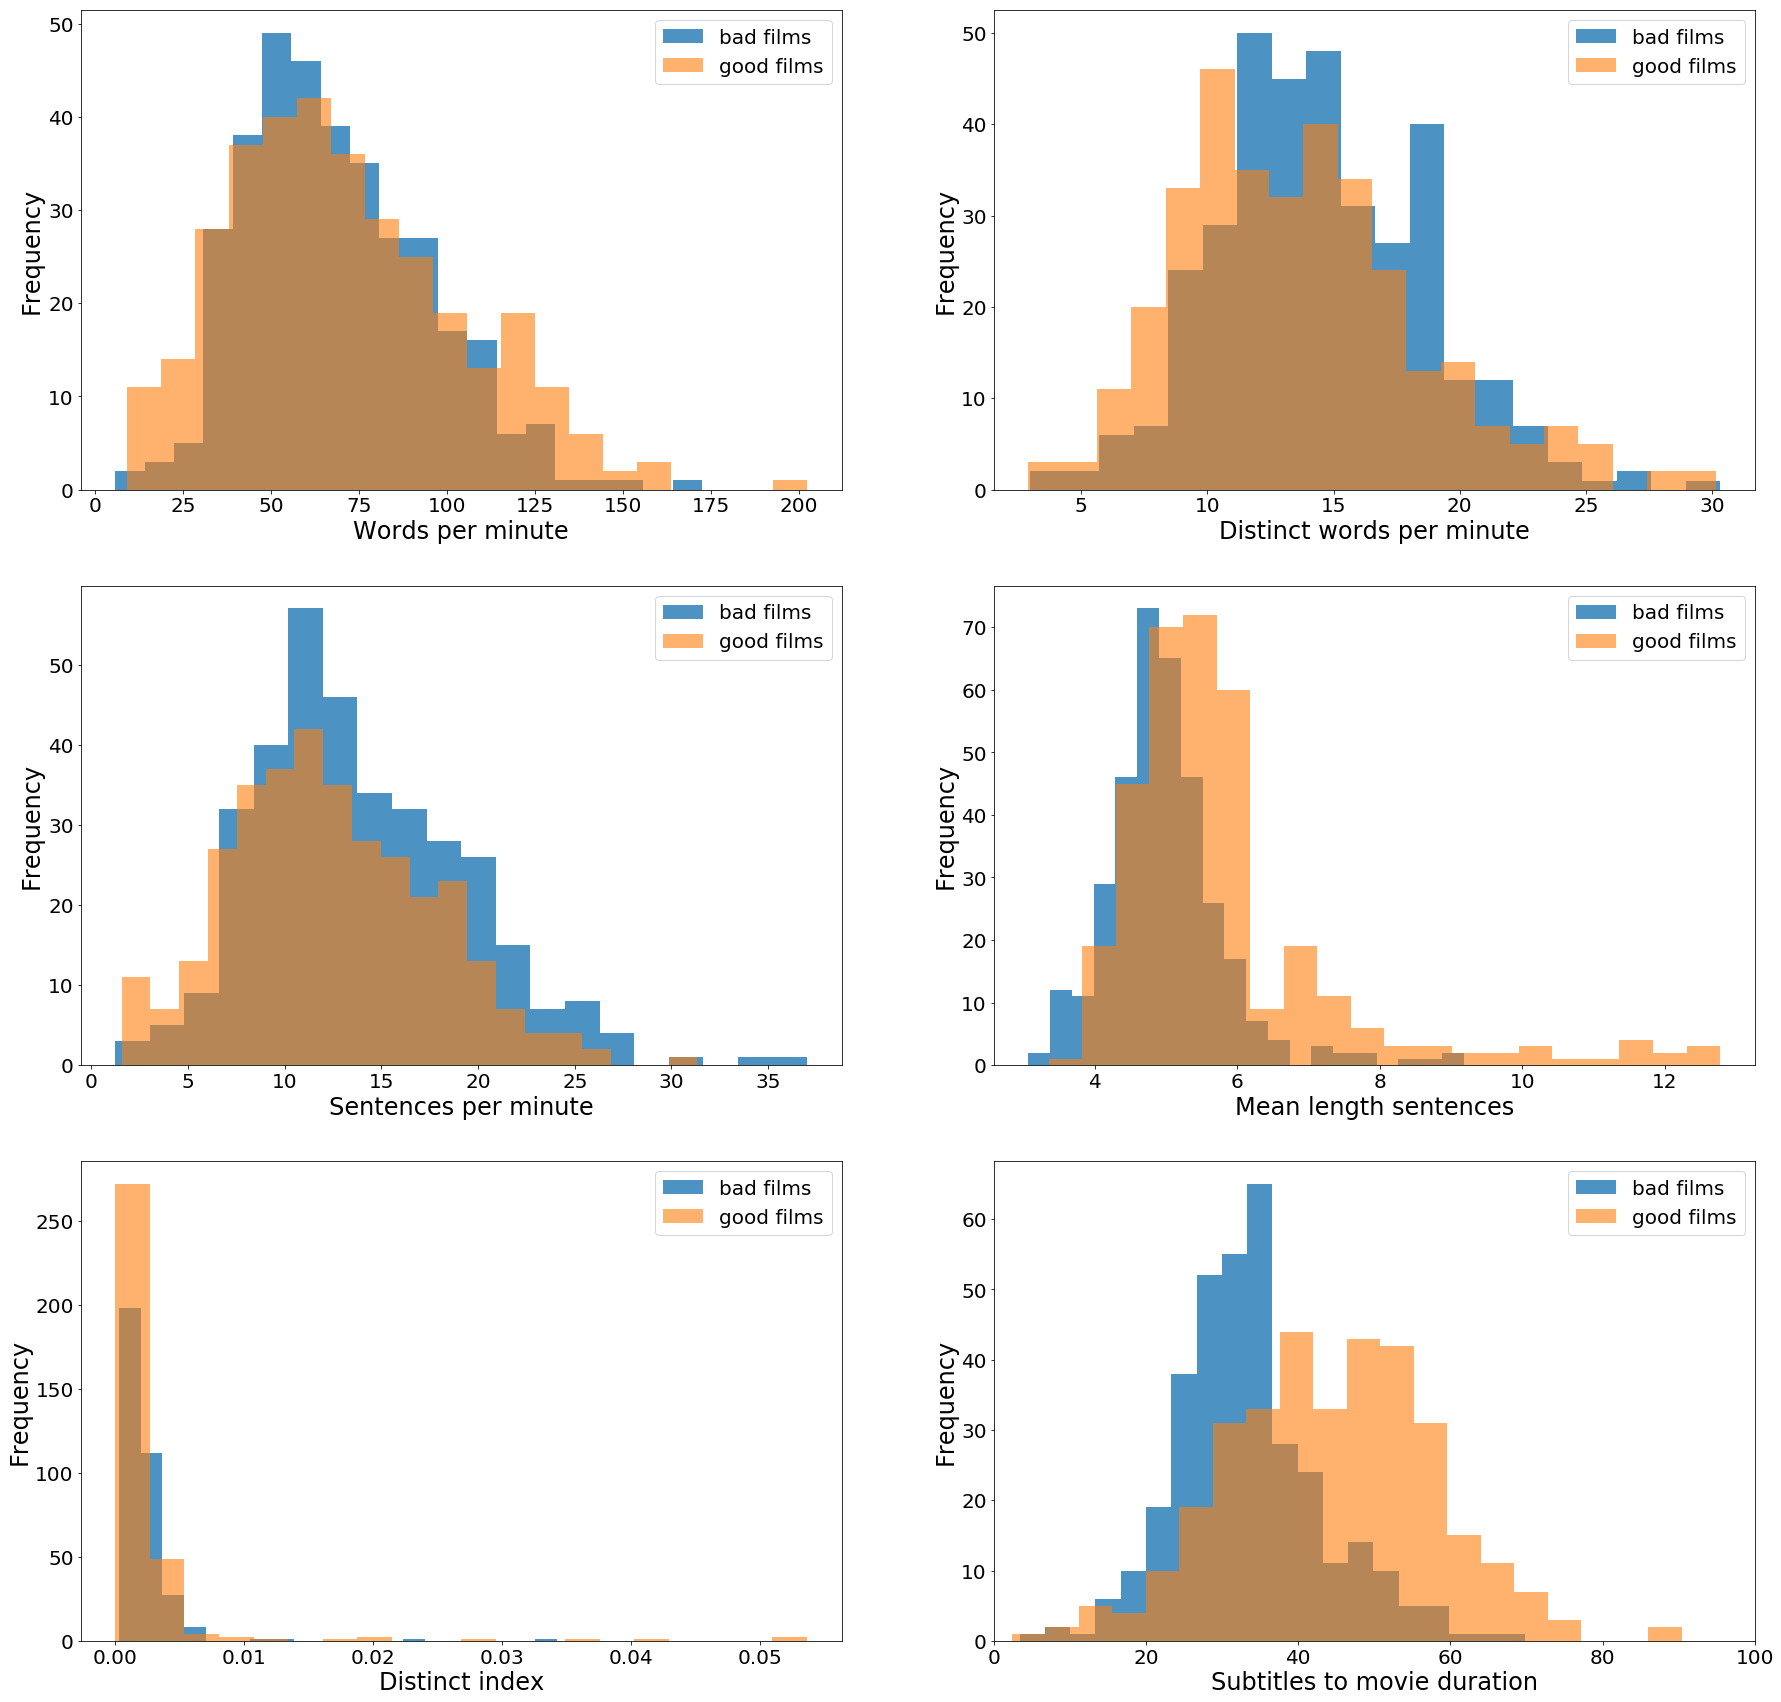

In [56]:
fig, axes = plt.subplots(nrows=3, 
                         ncols=2, 
                         figsize=(30,30))

bad_movies["words_per_min"].plot(kind="hist",
                                 ax=axes[0,0],
                                 fontsize=20, 
                                 alpha=0.8, 
                                 label="bad films", 
                                 bins=20)
good_movies["words_per_min"].plot(kind="hist",
                                  ax=axes[0,0],
                                  fontsize=20,
                                  alpha=0.6, 
                                  label="good films",
                                  bins=20)

bad_movies["distinct_words_per_min"].plot(kind="hist",
                                          ax=axes[0,1],
                                          fontsize=20, 
                                          alpha=0.8,  
                                          label="bad films", 
                                          bins=20)
good_movies["distinct_words_per_min"].plot(kind="hist",
                                           ax=axes[0,1],
                                           fontsize=20,
                                           alpha=0.6, 
                                           label="good films", 
                                           bins=20)

bad_movies["sentences_per_min"].plot(kind="hist",
                                     ax=axes[1,0],
                                     fontsize=20, 
                                     alpha=0.8,  
                                     label="bad films", 
                                     bins=20)
good_movies["sentences_per_min"].plot(kind="hist",
                                      ax=axes[1,0],
                                      fontsize=20,
                                      alpha=0.6, 
                                      label="good films", 
                                      bins=20)

bad_movies["mean_length_sentences"].plot(kind="hist",
                                         ax=axes[1,1],
                                         fontsize=20, 
                                         alpha=0.8,  
                                         label="bad films", 
                                         bins=20)
good_movies["mean_length_sentences"].plot(kind="hist",
                                          ax=axes[1,1],
                                          fontsize=20,
                                          alpha=0.6, 
                                          label="good films", 
                                          bins=20)

bad_movies["distinct_index"].plot(kind="hist",
                                  ax=axes[2,0],
                                  fontsize=20, 
                                  alpha=0.8,  
                                  label="bad films", 
                                  bins=20)
good_movies["distinct_index"].plot(kind="hist",
                                   ax=axes[2,0],
                                   fontsize=20,
                                   alpha=0.6, 
                                   label="good films", 
                                   bins=20)

bad_movies["times_ratio"].plot(kind="hist",
                               ax=axes[2,1],
                               fontsize=20, 
                               alpha=0.8,  
                               label="bad films", 
                               bins=20)
good_movies["times_ratio"].plot(kind="hist",
                                ax=axes[2,1],
                                fontsize=20,
                                alpha=0.6, 
                                label="good films", 
                                bins=20)


axes[0,0].set_xlabel("Words per minute", 
                     fontsize=24)
axes[0,1].set_xlabel("Distinct words per minute", 
                     fontsize=24)
axes[1,0].set_xlabel("Sentences per minute", 
                     fontsize=24)
axes[1,1].set_xlabel("Mean length sentences", 
                     fontsize=24)
axes[2,0].set_xlabel("Distinct index", 
                     fontsize=24)
axes[2,1].set_xlabel("Subtitles to movie duration", 
                     fontsize=24)

axes[2,1].set_xlim(0,100)


axes[0,0].set_ylabel("Frequency", 
                     fontsize=24)
axes[1,0].set_ylabel("Frequency", 
                     fontsize=24)
axes[0,1].set_ylabel("Frequency", 
                     fontsize=24)
axes[1,1].set_ylabel("Frequency", 
                     fontsize=24)
axes[2,0].set_ylabel("Frequency", 
                     fontsize=24)
axes[2,1].set_ylabel("Frequency", 
                     fontsize=24)

axes[0,0].legend(loc="upper right", fontsize=20)
axes[0,1].legend(loc="upper right", fontsize=20)
axes[1,0].legend(loc="upper right", fontsize=20)
axes[1,1].legend(loc="upper right", fontsize=20)
axes[2,0].legend(loc="upper right", fontsize=20)
axes[2,1].legend(loc="upper right", fontsize=20)

plt.savefig('graphs/histograms.png')

As we can see from the resulting histograms, for all the different features we have distributions centered around the same values for both "good" and "bad" films.
There is however a difference in the deviation from feature to feature.
We can see for example that the mean sentence length for "good" films takes larger values.

We compute the difference between our groups descriptive statistics aswell to get numerical results.

In [57]:
(good_movies.describe()[features] - bad_movies.describe()[features]).loc[["mean", "std", "min", "max"]]

,words_per_min,distinct_words_per_min,sentences_per_min,mean_length_sentences,distinct_index,times_ratio
mean,2.117311,-0.893111,-1.685933,0.809133,0.000126,10.813665
std,7.160669,0.616405,-0.308778,0.736911,0.003043,3.942780
min,3.263637,-0.075649,0.330046,0.285602,-0.000262,-0.996837
max,29.841326,-0.173180,-5.672944,3.595510,0.019384,20.604732


We can see that indeed both "good" and "bad" movie feature distributions are centered in similar axes and that apart from sentences per minute, the "good" films tend to have bigger standard deviations per film. 

To summarize, based on these statistics, we cannot establish a default profile of what a "good" or "bad" movie is.  

# Trying to predict the IMDb average rating:

Even though we do not see clear dependencies between the features and the movie ratings, we combine the features to fit a linear regression model and see how well it predicts the ratings: a combination of the features could provide better results.  

In [58]:
feature_columns = ["words_per_min", "distinct_words_per_min",
                   "sentences_per_min","mean_length_sentences",
                   "distinct_index","times_ratio"]

In [59]:
X = df_words_ratings_pd[feature_columns]
normal_X = (X- X.mean()) /X.std()
normal_X = normal_X.fillna(0)
y = df_words_ratings_pd["averageRating"]

In [60]:
regression = LinearRegression()
predicted = cross_val_predict(regression, normal_X, y, cv=5)

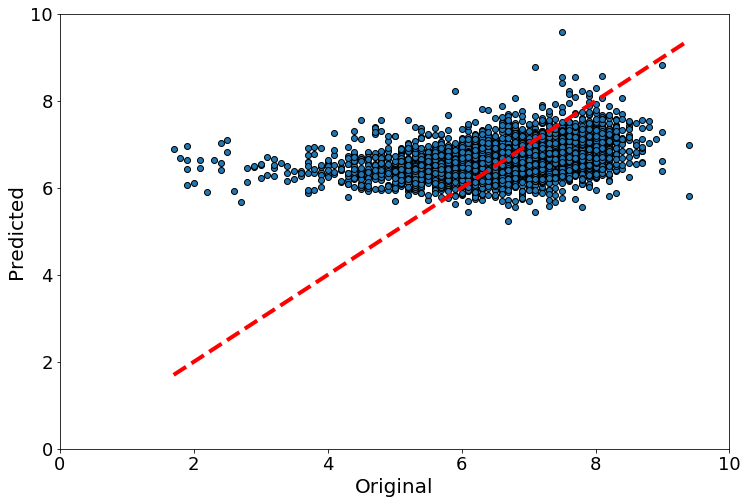

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
ax.set_xlabel('Original', fontsize=20)
ax.set_ylabel('Predicted', fontsize=20)
ax.set_xlim(0,10)
ax.set_ylim(0,10)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

If the regression had worked, all the points would be lying on the $y = x$ line plotted with a dashed red line. 
As expected, the mode cannot correctly predict the average IMDb rating.
Our model predicts that all films have a better rating than 6 which is very close to the average rating of 6.7 .
This means that the statistics we have are not sufficient to predict the average rating. 

# Text analysis

As our linear regression did not give us satisfying results in the prediction of the movies' average IMDb rating, we explore Natural Language Processing (NLP) tools to try to get a better insight of what makes a "good" and a "bad" movie.

## Sentiment Analysis

We implement a sentiment analysis to see if a movie's general sentiment has an influence on the final rating. 
We analyze all the sentences of a movie and extract the positive and negative sentiment score of each sentence.
With this values we compute the average positive and negative scores score for each subtitle file. 
The sentiment score of each sentence is computed using the NLP library SpaCy. 
We focus on the 100 best rated movies and 100 worst rated movies to begin as the computations can be quite heavy.

In [62]:
nlp = spacy.load('en')

In [63]:
# Load the raw subtitles 
df_films_strings = spark.read.parquet("parquets/filmtext.parquet/")

In [64]:
df_strings = df_films_strings.join(df_ratings, ["tconst"]).toPandas()

In [65]:
# Define function that computes the degree of positiveness and negativeness 
analyzer = SentimentIntensityAnalyzer()
def av_sentiments_film(text):
    document = nlp(text)
    positive_sent = 0
    negative_sent = 0
    sents = document.sents
    count = 0
    for sent in sents:
        positive_sent += analyzer.polarity_scores(sent.text)['pos']
        negative_sent += analyzer.polarity_scores(sent.text)['neg']
        count += 1
    return (positive_sent/count, negative_sent/count)

In [66]:
df_strings_best = df_strings.sort_values("averageRating", ascending=False).head(100)
df_strings_worst = df_strings.sort_values("averageRating", ascending=True).head(100)
df_strings_best["av_sentiment"] = df_strings_best["text"].apply(av_sentiments_film)
df_strings_worst["av_sentiment"] = df_strings_worst["text"].apply(av_sentiments_film)

In [67]:
df_strings_best[['positive', 'negative']] = df_strings_best['av_sentiment'].apply(pd.Series)
df_strings_worst[['positive', 'negative']] = df_strings_worst['av_sentiment'].apply(pd.Series)

### Results 

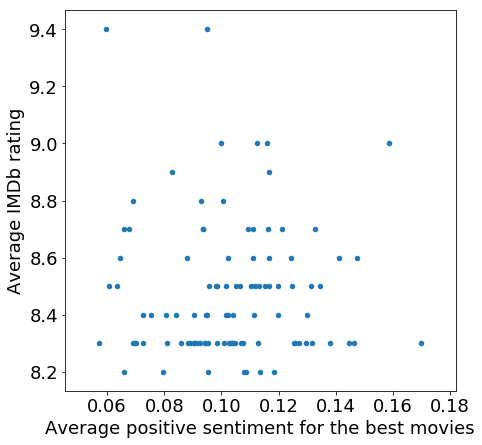

In [68]:
ax = df_strings_best.plot.scatter("positive", "averageRating", figsize=(7,7), fontsize= 18)
ax.set_xlabel("Average positive sentiment for the best movies", fontsize= 18)
ax.set_ylabel("Average IMDb rating", fontsize= 18)
plt.show()

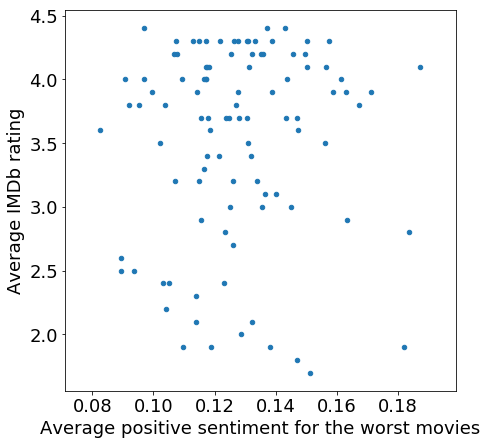

In [69]:
ax = df_strings_worst.plot.scatter("positive", "averageRating", figsize=(7,7), fontsize= 18)
ax.set_xlabel("Average positive sentiment for the worst movies", fontsize= 18)
ax.set_ylabel("Average IMDb rating", fontsize= 18)
plt.show()

In [70]:
print("The median positive sentiment of best movies is: {:.3f}".format(df_strings_best["positive"].median()))
print("The median positive sentiment of worst movies is: {:.3f}".format(df_strings_worst["positive"].median()))

The median positive sentiment of best movies is: 0.103
The median positive sentiment of worst movies is: 0.126


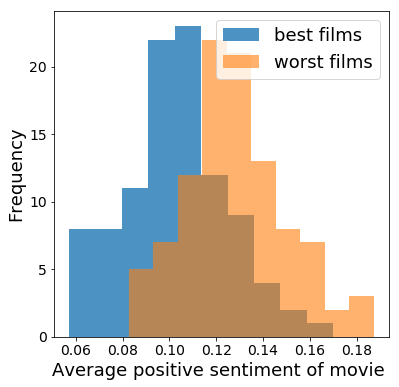

In [71]:
df_strings_best["positive"].plot.hist(alpha=0.8, label="best films")
df_strings_worst["positive"].plot.hist(alpha=0.6, label="worst films",figsize=(6,6),fontsize=14);
plt.xlabel('Average positive sentiment of movie ', fontsize=18);
plt.ylabel('Frequency', fontsize=18);
plt.legend(loc='upper right', fontsize=18)
plt.show()

As we can see for the positive sentiment, the median of both "good" and "bad" films data is very close in value and with the plots we have we can also see how there does not seem to be any mayor dependency between the average rating and the positive sentiment in a film. 
The histograms show only that "good" films are slightly less “positive” than "bad" films.

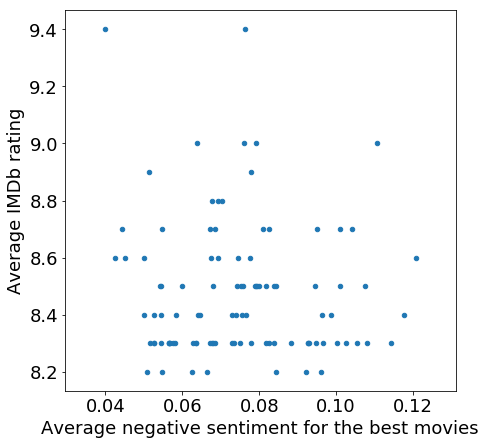

In [72]:
ax = df_strings_best.plot.scatter("negative", "averageRating", figsize=(7,7), fontsize= 18)
ax.set_xlabel("Average negative sentiment for the best movies", fontsize= 18)
ax.set_ylabel("Average IMDb rating", fontsize= 18)
plt.show()

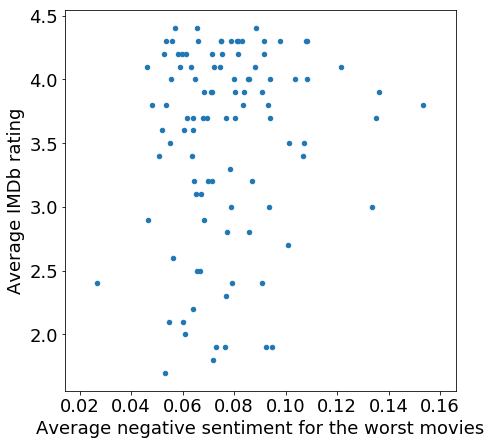

In [73]:
ax = df_strings_worst.plot.scatter("negative", "averageRating", figsize=(7,7), fontsize= 18)
ax.set_xlabel("Average negative sentiment for the worst movies", fontsize= 18)
ax.set_ylabel("Average IMDb rating", fontsize= 18)
plt.show()

In [74]:
print("The median positive sentiment of best movies is: {:.3f}".format(df_strings_best["negative"].median()))
print("The median positive sentiment of worst movies is: {:.3f}".format(df_strings_worst["negative"].median()))

The median positive sentiment of best movies is: 0.074
The median positive sentiment of worst movies is: 0.075


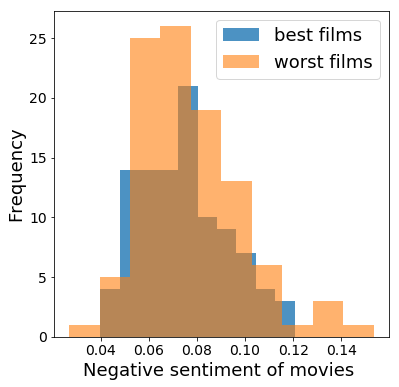

In [75]:
df_strings_best["negative"].plot.hist(alpha=0.8, label="best films")
df_strings_worst["negative"].plot.hist(alpha=0.6, label="worst films",figsize=(6,6),fontsize=14);
plt.xlabel('Negative sentiment of movies ', fontsize=18);
plt.ylabel('Frequency', fontsize=18);
plt.legend(loc='upper right', fontsize=18)
plt.show()

Now for the negative sentiment we get unsurprisingly the same results, the difference between the medians is even smaller and the scatter plots again reveal no real descrepancy. We also see from the histograms that the distributions are very similar.

As we don’t see any promising leads to follow here either, we do not perform the analysis of sentiments on the whole dataset. 
We only conclude that "good" films are a bit less positive than the bad films and we continue our research by implementing a topic detection.

## Topic Detection

Finally, we look into 4 of the most represented genres in our dataset and look into the different recurrent topics of each genre for the predefined "good" and bad movies. 
The results are unfortunately quite subjective as the detected topics are not necessarily easy to label. 
The goal is to recommend topics to be avoided or to be used when writing a movie, based on topics of previous "good" or bad movies.

We interpret the results the best we can to determine the recurring topics of each genre given the quality of the movie and we summarize our analysis in the following section.


The topic extraction is performed using Latent Dirichlet Allocation implemented by the gensim library.

### Start of processing 

In [76]:
# Load data 
# Keeping only the subtiles
df_text = spark.read.parquet('parquets/films2_3.parquet').select('tconst','subtitles')
df_ratings = spark.read.parquet('parquets/ratings.parquet')
df_basics = spark.read.parquet('parquets/basics.parquet')

In [77]:
# Joining with ratings to get best and worst movies 
df_tr = df_text.join(other=df_ratings.select('tconst','averageRating'), on='tconst', how='inner')
df_tr = df_tr.join(other=df_basics.select('tconst','genres'), on='tconst', how='inner')

In [78]:
df_tr = df_tr.select("tconst",'averageRating', 'subtitles',psf.explode_outer("genres"))

df_best = df_tr.filter(df_tr['averageRating'] >= 8)
df_worst = df_tr.filter(df_tr['averageRating'] <= 5.2)

In [79]:
df_best.show()

+---------+-------------+--------------------+---------+
|   tconst|averageRating|           subtitles|      col|
+---------+-------------+--------------------+---------+
|tt0032553|          8.5|[[At, the, end, o...|   Comedy|
|tt0032553|          8.5|[[At, the, end, o...|    Drama|
|tt0032553|          8.5|[[At, the, end, o...|      War|
|tt0032599|          8.0|[[Copy, boy], [Ma...|   Comedy|
|tt0032599|          8.0|[[Copy, boy], [Ma...|    Drama|
|tt0032599|          8.0|[[Copy, boy], [Ma...|  Romance|
|tt0038733|          8.1|[[This, is, the, ...|   Comedy|
|tt0038733|          8.1|[[This, is, the, ...|    Drama|
|tt0038733|          8.1|[[This, is, the, ...|  Fantasy|
|tt0063522|          8.0|[[La, la, la], [L...|    Drama|
|tt0063522|          8.0|[[La, la, la], [L...|   Horror|
|tt2488496|          8.0|[[A, long, time, ...|   Action|
|tt2488496|          8.0|[[A, long, time, ...|Adventure|
|tt2488496|          8.0|[[A, long, time, ...|  Fantasy|
|tt3783958|          8.1|[[It, 

### Detokenizing the text

In [80]:
def subtitles_to_string(subtitles):
    result = ""
    for subtitle in subtitles:
        test = MosesDetokenizer().detokenize(subtitle)
        result += test + "\n"
    return result
udf_subtitles_to_string = psf.udf(subtitles_to_string, StringType())

In [81]:
# Choosing best or worst 
df =  df_best #df_worst

# Choose genre to look 
genre = 'Comedy'

In [82]:
df = df.withColumn("text",
                   udf_subtitles_to_string("subtitles"))

df = df.drop('subtitles')

### NLP Pipe for genre

In [83]:
nlp = spacy.load('en')
nlp.remove_pipe('parser')
nlp.remove_pipe('tagger')

('tagger', <spacy.pipeline.Tagger at 0x1a2c7d0ef0>)

In [84]:
# Convert to Pandas 
df_pd = df.filter(df_best['col'] == genre).toPandas()

In [85]:
df_pd.count()

tconst           75
averageRating    75
col              75
text             75
dtype: int64

In [86]:
# Get subtitles 
texts_bests = df_pd['text'].values

In [87]:
# Remove new lines 
texts_bests = [" ".join(t.split()) for t in texts_bests]
# Convert caps to lowers 
texts_bests = [text.lower() for text in texts_bests]

In [88]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_docs = list()
for doc in nlp.pipe(texts_bests, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
    
docs = processed_docs #### v
del processed_docs

# Add bigrams to docs (only ones that appear 4 times or more).
bigram = Phrases(docs, min_count=4)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

# Create a dictionary representation of the documents, and filter out frequent and rare words.
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

seed = 42
# models
params = {'passes': 10, 'random_state': seed}
base_models = dict()

model = LdaMulticore(corpus=corpus,
                     num_topics=3,
                     id2word=dictionary,
                     workers=6,
                     passes=params['passes'],
                     random_state=params['random_state'])

sorted(model[corpus[0]],key=lambda x:x[1],reverse=True)

/Users/xrubiato/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Number of unique tokens: 3383
Number of chunks: 75


[(1, 0.6477738), (2, 0.25626332), (0, 0.095962904)]

### Plot topics

In [89]:
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

/Users/xrubiato/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Results

The number of considered movies for the detection of top 3 topics is written next to the genre in the heading.
Recomendations are either for topics to be used or avoided : use those of "good" movies and avoid those of "bad" movies. 
Recommendations of topics found on larger number of movies can be attributed greater confidence but are more difficult to label as they group a wider and more diverse array of words. 

_N.B. all topics are written in between ""._

#### Drama: (good: 246 |  bad: 89 )
Most of the good dramas in our dataset conerned related to "crimes", "justice", and "family".


For bad dramas in general it is very hard to establish a recurrent topic, from the words given we can point out the topic of marriage but also the topic of "police" is present.


"police" and "crimes" and very closely related topics that actually could be resumed in one.
This tell us that many movies considered as dramas tell stories about this topic and hence, "good" an "bad" movies came out of it. 

#### Comedy: (good: 75 |  bad: 146 )
For comedy movies we can say that if they tackle the holidays as a topic, it can be both a very "good" film or a very "bad" film. 
The difference lies in that the "good" holiday comedies are centered around "family" and the bad ones on "sex" and "teen dramas".
From the data we found as well that spoof comedies and movies set during the middle ages/renaissance  are not well received.
Finally "good" comedies deal often with the topics of "government", "war", "religion" and "morality".

#### Action: (good: 37 |  bad: 96 )
A relevant topic present in "good" action movies is "justice", while it is not as noticeable in bad action movies.
"Good" and "bad" action movies often focus on war, police, the military but from the data we could infer that the scenarios present in "good" action movies are realistic, while the ones in bad action movies are often something like an "alien invasion". 
"Romance" is not a dominant topic in the "good" films set but it is in the "bad" films set.

#### Romance: (good: 56 |  bad: 37 )
For "good" romantic films we have an occurrence of "war" related topics, stories that involve some kind of "goodbye".
We also see in the bag of words the topics of a "young", "college" and "romance".
Finally we see that movies which treat the subject of "affairs" also tend to be well received.
For the unpopular romance movies we see that the most present, distinguishable topics are sex (treated in a vulgar manner using words such as bitch, fuck, etc) and the holidays again. 

# Conclusion 

In order to predict the average IMDb rating, we tried to extract statistical features from the movie subtitles. Unfortunately, this method did not lead to great results as very few features were correlated with the average IMDb rating. Trying to get a sentiment score using NLP tools did not provide much more information on what makes a "good" and a "bad" movie. Finally, we thought that detecting topics would provide us better insight. We were not able to generate a recipe for a good movie but at least we came with proof of what everybody thinks: movies are more than just text. A movie is a combination of sound, text and image and all these aspects are important to make a good movie. The script might be complex, funny, thought-provoking but if the actors are bad, the camera work is not appealing, the music off, the movie cannot possibly be enjoyable.